In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statistics

## Structural variant gold set

## Inversions from valik

In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 11
BIGGER_SIZE = 14

plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

c_darkblue = "#4c6c9c"
c_darkgreen = "#5e8f7b"
c_purple = "#947db0"

In [3]:
def read_stellar_output(filename):
    df = pd.read_csv(filename, sep = "\t", header = None)
    df.drop([1, 2, 7], axis = 1, inplace = True) 
    df.columns = ["dname", "dbegin", "dend", "percid", "strand", "attr"]
    df["len"] = np.abs(df["dend"] - df["dbegin"])
    df[['qname','seq2Range', 'evalue', 'cigar', 'mutations']] = df['attr'].str.split(';',expand=True)
    df[["qbegin", "qend"]] = df["seq2Range"].str.removeprefix("seq2Range=").str.split(',',expand=True)
    df.drop(["cigar", "mutations", "evalue", "attr", "seq2Range"], axis = 1, inplace = True)
    for col in ["dbegin", "dend", "qbegin", "qend"]:
        df[col] = pd.to_numeric(df[col])
    return df

Pick reads that align to both strands

In [19]:
def get_split_variants(variants):
    split_read_variants = pd.DataFrame().reindex(columns=variants.columns) 
    split_reads = []
    for qname in np.unique(variants["qname"]): 
        query_matches = variants[variants["qname"] == qname]
        for dname in np.unique(query_matches["dname"]):
            chr_query_matches = query_matches[query_matches["dname"] == dname]
            if (len(chr_query_matches) > 3):
                if (len(np.unique(chr_query_matches["strand"])) == 2):
                    split_reads.append(qname)
                    split_read_variants = pd.concat([split_read_variants, chr_query_matches])
                    break

    variants = split_read_variants
    return variants

Switch database begin and end for variants on the minus strand

In [5]:
def switch_reverse_coord(variants):
    plus = variants[variants["strand"] == "+"].copy()
    minus = variants[variants["strand"] == "-"].copy()
    minus["tmp"] = minus["dbegin"].copy()
    minus["dbegin"] = minus["dend"].copy()
    minus["dend"] = minus["tmp"]
    minus.drop(["tmp"], inplace = True, axis = 1)
    variants = pd.concat([plus, minus])
    for col in ["dbegin", "dend", "qbegin", "qend"]:
        variants[col] = pd.to_numeric(variants[col])
    return variants

### Find best fitting line

In [6]:
def line_params(best_matches):
    i = 0

    x1 = best_matches["dbegin"].iloc[i]
    x2 = best_matches["dend"].iloc[i]
    y1 = best_matches["qbegin"].iloc[i]
    y2 = best_matches["qend"].iloc[i]

    a = (y2 - y1) / (x2 - x1)
    b = y1 - a * x1
    return [a, b]

def get_line(a, b):
    y_line = [0, 14000]
    x_line = []
    for y in y_line:
        x_line.append((y - b) / a)
    return x_line

In [7]:
def fit_line_coord(variants):
    variants = variants.assign(a = lambda x: ((x["qend"] - x["qbegin"]) / (x["dend"] - x["dbegin"])))
    variants = variants.assign(b = lambda x: (x["qbegin"] - x["a"] * x["dbegin"]))

    return variants

Find alignments that are on the same line

In [8]:
def get_aligned(df, max_offset):
    min_seq_range = 100
    read_len = 20000
    read_sets = []
    split_reads = []
    #chr_dict = {k:[] for k in np.unique(df["dname"])}

    for index, row in df.iterrows():
        query_matches = df[(df["qname"] == row["qname"]) & 
                        (df["dname"] == row["dname"])]
        if (row["dname"] not in ["chrY", "chr16_KI270728v1_random"]):
            if (len(np.unique(query_matches["strand"])) == 2):
                region_matches = query_matches[(query_matches["dbegin"] > row["dbegin"] - row["qbegin"]) & 
                                            (query_matches["dend"] < row["dend"] + read_len - row["qend"])]
                b = row["b"]
                b_matches = region_matches[(region_matches["b"] > b - max_offset) & (region_matches["b"] < b + max_offset)]
                if (np.max(b_matches["dbegin"]) - np.min(b_matches["dbegin"]) > min_seq_range): 
                    if (np.max(b_matches["qbegin"]) - np.min(b_matches["qbegin"]) > min_seq_range): 
                        if len(b_matches) > 2:
                            #chr_dict[row["dname"]].append(row["qname"])
                            split_reads.append(row["qname"])
                            read_sets.append(b_matches)
                            print(str(len(split_reads)) + "\t" + str(row["qname"]))
    return [read_sets, split_reads]

def get_aligned_single_strand(df, max_offset):
    min_seq_range = 200
    read_len = 20000
    read_sets = []
    split_reads = []
    #chr_dict = {k:[] for k in np.unique(df["dname"])}

    for index, row in df.iterrows():
        query_matches = df[(df["qname"] == row["qname"]) & 
                           (df["dname"] == row["dname"])]
        if (row["dname"] not in ["chrY", "chr16_KI270728v1_random"]):
            region_matches = query_matches[(query_matches["dbegin"] > (row["dbegin"] - row["qbegin"] * 2)) & 
                                            (query_matches["dend"] < row["dend"] + read_len - row["qend"])]
            
            b = row["b"]
            b_matches = region_matches[(region_matches["b"] > b - max_offset) & (region_matches["b"] < b + max_offset)]
            if (np.max(b_matches["dbegin"]) - np.min(b_matches["dbegin"]) > min_seq_range): 
                if (np.max(b_matches["qbegin"]) - np.min(b_matches["qbegin"]) > min_seq_range): 
                    if len(b_matches) > 1:
                        #chr_dict[row["dname"]].append(row["qname"])
                        split_reads.append(row["qname"])
                        read_sets.append(b_matches)
                        print(str(len(split_reads)) + "\t" + str(row["qname"]))
    return [read_sets, split_reads]

### Plot inversion

In [9]:
def get_other_strand(variants, best_matches):
    other_strand = "-"
    if (best_matches["strand"].iloc[0] == "-"):
        other_strand = "+"

    other_strand_matches = variants[(variants["qname"] == best_matches["qname"].iloc[0]) & 
                                    (variants["dname"] == best_matches["dname"].iloc[0]) & 
                                    (variants["strand"] == other_strand)]

    # not fur inverted duplications
    other_strand_matches = other_strand_matches[~other_strand_matches["qbegin"].isin(best_matches["qbegin"])] 
    other_strand_matches = other_strand_matches[~other_strand_matches["qend"].isin(best_matches["qend"])]
    return other_strand_matches

def plot_inversion(matches):
    for index, row in matches.iterrows():
        if row["strand"] == "+":
            plt.plot(np.array(row[["dbegin", "dend"]]), np.array(row[["qbegin", "qend"]]), 'b-', label = row["b"])
        else:
            plt.plot(np.array(row[["dbegin", "dend"]]), np.array(row[["qbegin", "qend"]]), 'r-', label = row["b"])

    y_range = np.max(matches["qend"]) - np.min(matches["qbegin"])
    x_range = np.max(matches["dend"]) - np.min(matches["dbegin"])

    if (y_range > x_range):
        plt.ylim(np.min(matches["qbegin"]) - round(y_range * 0.1), np.max(matches["qend"]) + round(y_range * 0.1))
        x_mean = round((np.max(matches["dbegin"]) + np.min(matches["dend"])) / 2)
        plt.xlim(x_mean - round(y_range * 1.1) / 2, x_mean + round(y_range * 1.1) / 2)
    else:
        plt.xlim(np.min(matches["dbegin"]) - round(x_range * 0.1), np.max(matches["dend"]) + round(x_range * 0.1))
        y_mean = round((np.max(matches["qbegin"]) + np.min(matches["qend"])) / 2)
        plt.ylim(y_mean - round(x_range * 1.1) / 2, y_mean + round(x_range * 1.1) / 2)
    
    
    plt.xlabel("GRCh38")
    plt.ylabel(matches["qname"].iloc[0])
    plt.title(matches["dname"].iloc[0])
    plt.tight_layout()
    plt.show()

### Breakpoint

In [10]:
def get_best_aligned(df, max_offset, min_seq_count, min_seq_range, single_strand):
    read_len = 10000
    read_sets = []
    split_reads = []
    #chr_dict = {k:[] for k in np.unique(df["dname"])}
    df = df[~df["dname"].isin(["chrY", "chr16_KI270728v1_random"])]    
    for qname in np.unique(df.qname):
        for dname in np.unique(df.dname):
            best_query_set = []
            best_score = 0
            query_matches = df[(df["qname"] == qname) & (df["dname"] == dname)]
            for index, row in query_matches.iterrows():
                region_matches = query_matches[(query_matches["dbegin"] > row["dbegin"] - row["qbegin"]) & 
                                                (query_matches["dend"] < row["dend"] + read_len - row["qend"])].copy()

                if (single_strand or len(np.unique(region_matches["strand"])) == 2):
                    a = row["a"]
                    b = row["b"]

                    region_matches = region_matches[region_matches.strand == row.strand]
                    #print(str(len(region_matches)) + " matches in region")
                        
                    x = (row["dbegin"] + row["dend"]) / 2
                    # fit line of current match
                    region_matches["horizontal_error"] = abs( region_matches["qbegin"] - (a * region_matches["dbegin"] + b) )
                    #print(region_matches)
        
                    # exclude outliers
                    b_matches = region_matches[region_matches["horizontal_error"] < max_offset]
                    #print(str(len(b_matches)) + " matches in alignment")
                    #print("DB range" + str(np.max(b_matches["dbegin"]) - np.min(b_matches["dbegin"])))
                    #print("Query range" + str(np.max(b_matches["qbegin"]) - np.min(b_matches["qbegin"])))
                    if (min_seq_count == 1 or np.max(b_matches["dbegin"]) - np.min(b_matches["dbegin"]) > min_seq_range): 
                        if (min_seq_count == 1 or np.max(b_matches["qbegin"]) - np.min(b_matches["qbegin"]) > min_seq_range): 
                            if len(b_matches) >= min_seq_count:
                                set_score = np.max(b_matches["qbegin"]) - np.min(b_matches["qbegin"])
                                split_reads.append(qname)
                                read_sets.append(b_matches)
                                print(str(len(split_reads)) + "\t" + str(row["qname"]) + "\t" + str(row["dname"]))                                    
    
    return [read_sets, split_reads]

def get_single_aligned(df, max_offset, min_seq_count, min_seq_range, single_strand):
    read_len = 20000
    read_sets = []
    split_reads = []
    #chr_dict = {k:[] for k in np.unique(df["dname"])}
    df = df[~df["dname"].isin(["chrY", "chr16_KI270728v1_random"])]    
    for qname in np.unique(df.qname):
        best_query_set = []
        best_score = 0    
        for dname in np.unique(df.dname):
            query_matches = df[(df["qname"] == qname) & (df["dname"] == dname)]
            for index, row in query_matches.iterrows():
                region_matches = query_matches[(query_matches["dbegin"] > row["dbegin"] - row["qbegin"]) & 
                                                (query_matches["dend"] < row["dend"] + read_len - row["qend"])].copy()
                if (single_strand or len(np.unique(region_matches["strand"])) == 2):
                    a = row["a"]
                    b = row["b"]

                    region_matches = region_matches[region_matches.strand == row.strand]
                    #print(str(len(region_matches)) + " matches in region")
                        
                    x = (row["dbegin"] + row["dend"]) / 2
                    # fit line of current match
                    region_matches["horizontal_error"] = abs( region_matches["qbegin"] - (a * region_matches["dbegin"] + b) )
                    #print(region_matches)
        
                    # exclude outliers
                    b_matches = region_matches[region_matches["horizontal_error"] < max_offset]
                    #print(str(len(b_matches)) + " matches in alignment")
                    #print("DB range" + str(np.max(b_matches["dbegin"]) - np.min(b_matches["dbegin"])))
                    #print("Query range" + str(np.max(b_matches["qbegin"]) - np.min(b_matches["qbegin"])))
                    if (min_seq_count == 1 or np.max(b_matches["dbegin"]) - np.min(b_matches["dbegin"]) > min_seq_range): 
                        if (min_seq_count == 1 or np.max(b_matches["qbegin"]) - np.min(b_matches["qbegin"]) > min_seq_range): 
                            if len(b_matches) >= min_seq_count:
                                set_score = np.max(b_matches["qbegin"]) - np.min(b_matches["qbegin"])
                                if (set_score > best_score):
                                    best_query_set = b_matches
            
        if (len(best_query_set) != 0):
            split_reads.append(qname)
            read_sets.append(best_query_set)
            print(str(len(split_reads)) + "\t" + str(row["qname"]) + "\t" + str(row["dname"]))                                    
    
    return [read_sets, split_reads]

In [33]:
def plot_all_inversions(read_sets, variants):
    i = 0
    other_set_sets = []
    for best_matches in read_sets:
        if (best_matches["dname"].iloc[0] != "false"):
            other_strand = "-"
            if (best_matches["strand"].iloc[0] == "-"):
                other_strand = "+"

            other_strand_matches = df[(df["qname"] == best_matches["qname"].iloc[0]) & 
                                      (df["dname"] == best_matches["dname"].iloc[0]) & 
                                      (df["strand"] == other_strand)].copy()

            other_strand_matches["sum"] = (other_strand_matches["dbegin"] + other_strand_matches["dend"] + 
                                           other_strand_matches["qbegin"] + other_strand_matches["qend"]) // 10
            other_strand_matches.sort_values(["sum", "len"], inplace = True)
            other_strand_matches.drop_duplicates(subset = ["sum"], inplace = True)
            
            other_strand_matches = other_strand_matches[(other_strand_matches["dbegin"] > (np.min(best_matches["dbegin"]) - 5000)) & 
                                                (other_strand_matches["dbegin"] < (np.max(best_matches["dbegin"]) + 5000))]
            print("Match count on other strand\t" + str(len(other_strand_matches)))
            if (len(other_strand_matches) > 0):
                other_read_sets, other_split_reads = get_best_aligned(other_strand_matches, 
                                                                        max_offset = 100,
                                                                        min_seq_count = 3, 
                                                                        min_seq_range = 50, 
                                                                        single_strand = True)
                other_set_sets.append(other_read_sets)
                
                print("Other strand match set count\t" + str(len(other_set_sets)))
                for other_best in other_read_sets:
                    plot_inversion(pd.concat([best_matches, other_best]))
            else:
                other_set_sets.append([])
            i += 1
    return other_set_sets

### chr2 inversion

In [20]:
df = read_stellar_output("HG00731.inversion.chr2.gff")
len(df)

376

In [21]:
df = switch_reverse_coord(df)
df = fit_line_coord(df)
df.head()

,dname,dbegin,dend,percid,strand,len,qname,qbegin,qend,a,b
0,chr2,89832518.0,89832724.0,85.2380,+,206.0,m54329U_190531_175004/98699610/ccs,2668.0,2869.0,0.975728,-8.764945e+07
1,chr2,89833094.0,89833300.0,85.1851,+,206.0,m54329U_190531_175004/98699610/ccs,2661.0,2868.0,1.004854,-9.026652e+07
3,chr2,89831054.0,89831260.0,85.3773,+,206.0,m54329U_190531_175004/98699610/ccs,3260.0,3464.0,0.990291,-8.895565e+07
4,chr2,89828190.0,89828397.0,85.4460,+,207.0,m54329U_190531_175004/98699610/ccs,3260.0,3463.0,0.980676,-8.808912e+07
7,chr2,89832150.0,89832357.0,85.2534,+,207.0,m54329U_190531_175004/98699610/ccs,5200.0,5411.0,1.019324,-9.156284e+07


m54329U_190528_231241/23988940/ccs


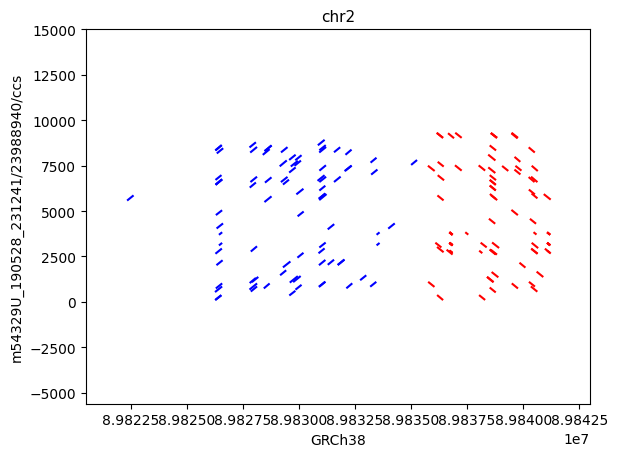

m54329U_190531_175004/98699610/ccs


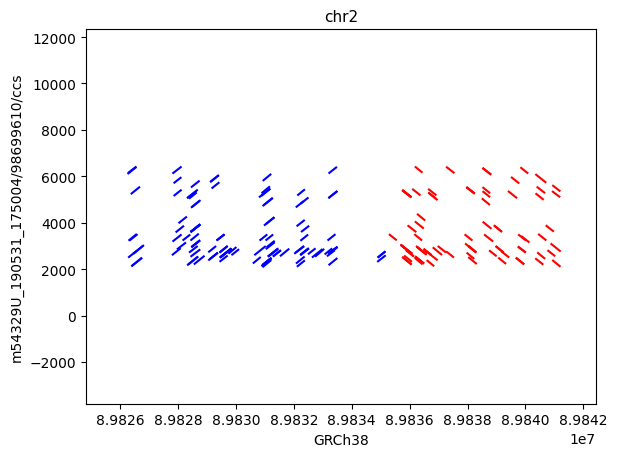

In [22]:
for qname in np.unique(df["qname"]):
    print(qname)
    plot_inversion(df[df["qname"] == qname])

In [23]:
df = df[df["qname"] == "m54329U_190528_231241/23988940/ccs"]
max_offset = 2000
min_seq_count = 2 
min_seq_range = 6500
single_strand = False
#df = df[df["dbegin"] > 8.9828 * 1e7]
read_sets, split_reads = get_single_aligned(df, max_offset, min_seq_count, min_seq_range, single_strand)

1	m54329U_190528_231241/23988940/ccs	chr2


Match count on other strand	59
1	m54329U_190528_231241/23988940/ccs	chr2
2	m54329U_190528_231241/23988940/ccs	chr2
3	m54329U_190528_231241/23988940/ccs	chr2
4	m54329U_190528_231241/23988940/ccs	chr2
5	m54329U_190528_231241/23988940/ccs	chr2
6	m54329U_190528_231241/23988940/ccs	chr2
7	m54329U_190528_231241/23988940/ccs	chr2
8	m54329U_190528_231241/23988940/ccs	chr2
9	m54329U_190528_231241/23988940/ccs	chr2
10	m54329U_190528_231241/23988940/ccs	chr2
11	m54329U_190528_231241/23988940/ccs	chr2
12	m54329U_190528_231241/23988940/ccs	chr2
13	m54329U_190528_231241/23988940/ccs	chr2
14	m54329U_190528_231241/23988940/ccs	chr2
Other strand match set count	1


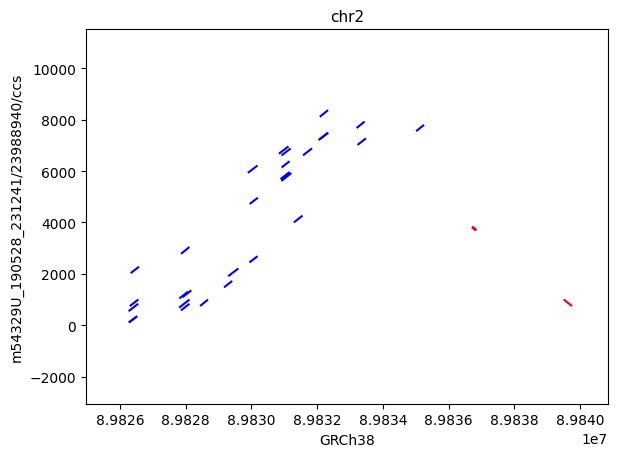

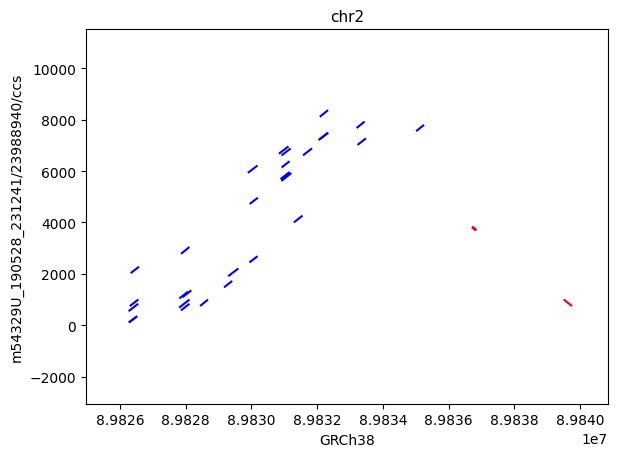

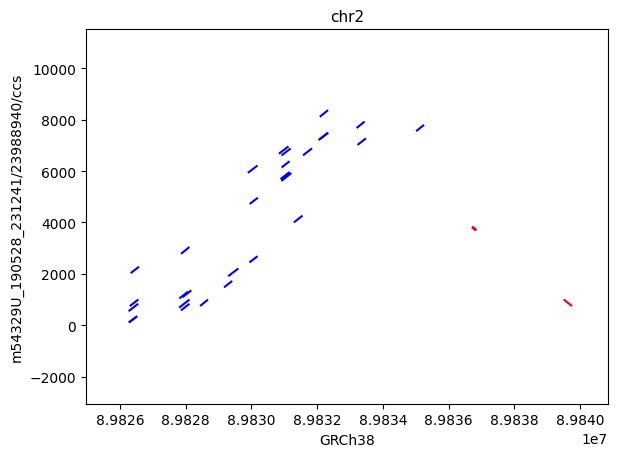

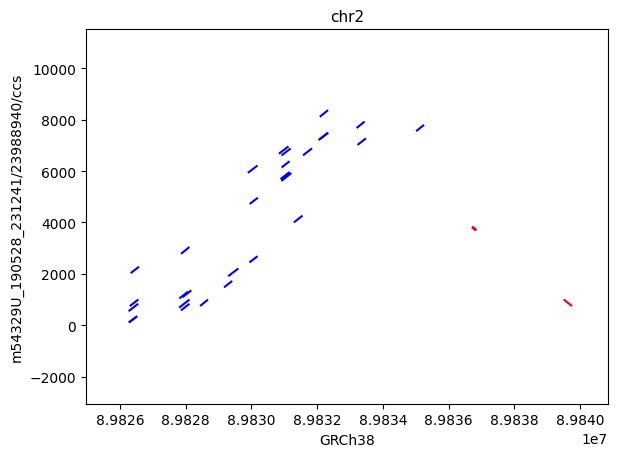

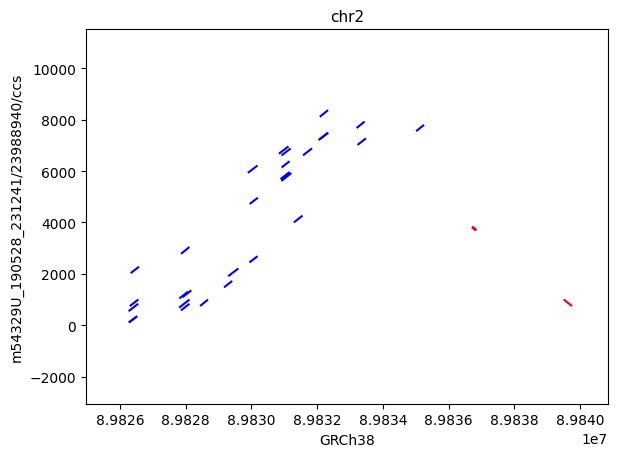

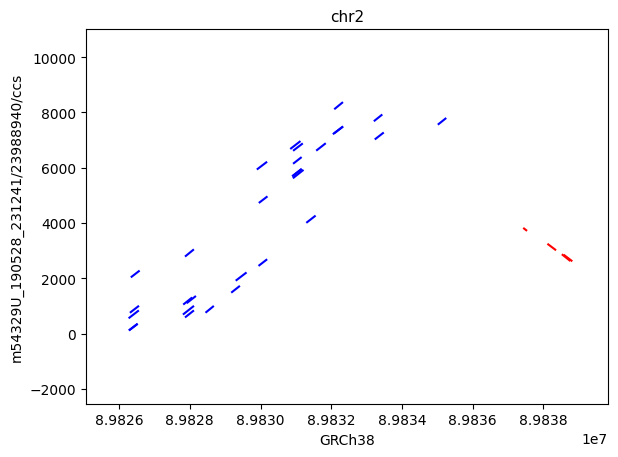

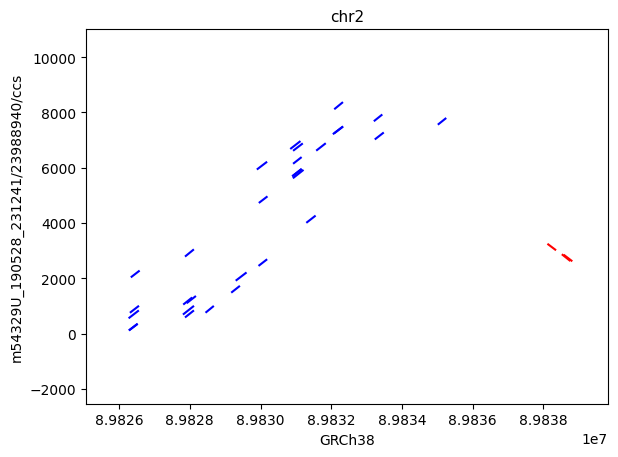

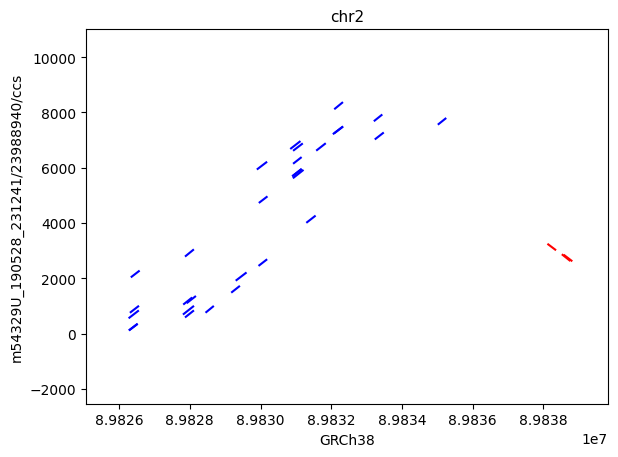

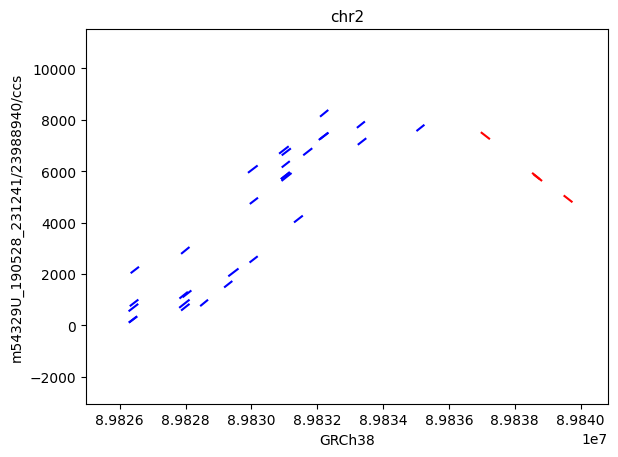

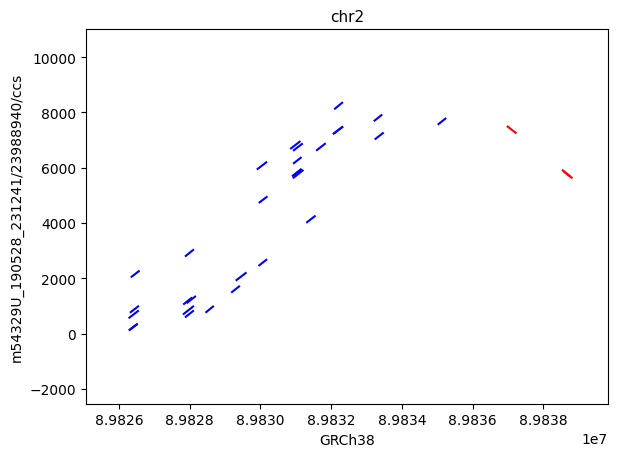

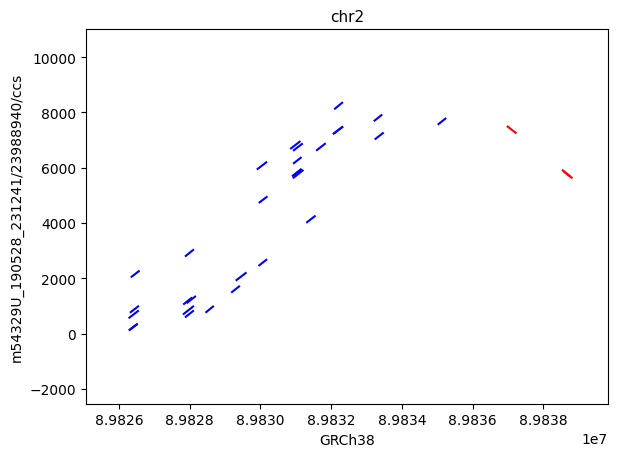

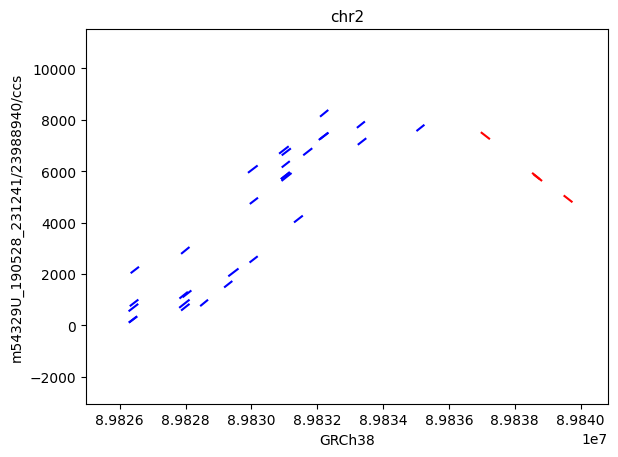

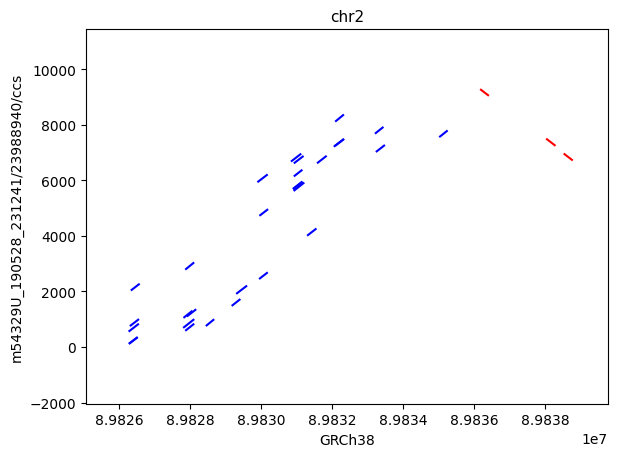

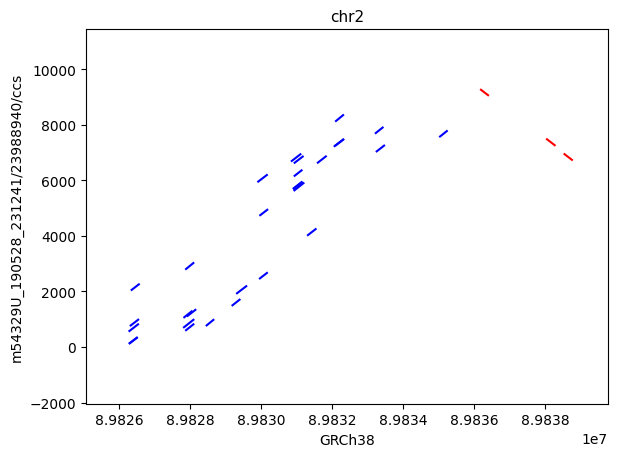

In [34]:
other_set_sets = plot_all_inversions(read_sets, df)

In [35]:
def plot_breakpoint(df, above_set, below_set, inv_set):
    fig, ax = plt.subplots(1, 2, sharey = True)
    ax[0].set_box_aspect(9/12)
    ax[1].set_box_aspect(9/12)
    fig.set_figwidth(9)
    fig.set_figheight(3.5)

    absolute_range = [round(np.min(below_set["dbegin"])) - 500, round(np.min(below_set["dbegin"])) - 500 + 12000]
    # relative position on database seq
    rel_pos_corr = np.min(below_set["dbegin"]) - 500
    print(rel_pos_corr)
    df["dbegin"] = df["dbegin"] - rel_pos_corr
    df["dend"] = df["dend"] - rel_pos_corr

    above_set["dbegin"] = above_set["dbegin"] - rel_pos_corr
    above_set["dend"] = above_set["dend"] - rel_pos_corr

    below_set["dbegin"] = below_set["dbegin"] - rel_pos_corr
    below_set["dend"] = below_set["dend"] - rel_pos_corr

    inv_set["dbegin"] = inv_set["dbegin"] - rel_pos_corr
    inv_set["dend"] = inv_set["dend"] - rel_pos_corr

    matches = pd.concat([above_set, below_set, inv_set])
    y_range = np.max(matches["qend"]) - np.min(matches["qbegin"])
    x_range = np.max(matches["dend"]) - np.min(matches["dbegin"])
    for i in range(2):
        ax[i].set_ylim(0, 9000)
        ax[i].set_xlim(0, 12000)
        ax[i].set_yticks([0, 2000, 4000, 6000, 8000])
    
    if (False):
        if (y_range > x_range):
            min_y_lim = np.min(matches["qbegin"]) - round(y_range * 0.1)
            max_corr = 0
            if (min_y_lim < 0):
                max_corr = -min_y_lim
                min_y_lim = 0
                
            ax[i].set_ylim(min_y_lim, np.max(matches["qend"]) + round(y_range * 0.1) + max_corr)
            x_mean = round((np.max(matches["dbegin"]) + np.min(matches["dend"])) / 2)
            ax[i].set_xlim(x_mean - round(y_range * 1.1) / 2, x_mean + round(y_range * 1.1) / 2)
        else:
            ax[i].set_xlim(round(np.min(matches["dbegin"]) - x_range * 0.1), np.max(matches["dend"]) + round(x_range * 0.1))
            y_mean = round((np.max(matches["qbegin"]) + np.min(matches["qend"])) / 2)
            min_y_lim = round(y_mean - round(x_range * 1.1) / 2)
            max_corr = 0
            if (min_y_lim < 0):
                max_corr = -min_y_lim
                min_y_lim = 0
            
            ax[i].set_ylim(min_y_lim, y_mean + round(x_range * 1.1) / 2 + max_corr)
        print(ax[i].get_xticks())
        ax[i].set_yticks(ax[i].get_xticks())
    
    # left
    matches = pd.concat([df, inv_set])
    for index, row in matches.iterrows():
        if (row["strand"] == "+"):
            ax[0].plot(np.array(row[["dbegin", "dend"]]), np.array(row[["qbegin", "qend"]]), 'b-', label = row["b"], linewidth = 0.25)
        else:
            ax[0].plot(np.array(row[["dbegin", "dend"]]), np.array(row[["qbegin", "qend"]]), 'r-', label = row["b"], linewidth = 0.25)

    
    # right
    for index, row in df[df["qname"] == above_set["qname"].iloc[0]].iterrows():
        if row["strand"] == "+":
            ax[1].plot(np.array(row[["dbegin", "dend"]]), np.array(row[["qbegin", "qend"]]), 'b-', linewidth = 0.2)
        else:
            ax[1].plot(np.array(row[["dbegin", "dend"]]), np.array(row[["qbegin", "qend"]]), 'r-', linewidth = 0.2)
    
    matches = pd.concat([above_set, below_set, inv_set])
    for index, row in pd.concat([above_set, below_set]).iterrows():
        ax[1].plot(np.array(row[["dbegin", "dend"]]), np.array(row[["qbegin", "qend"]]), 'b-')

    for index, row in inv_set.iterrows():
        ax[1].plot(np.array(row[["dbegin", "dend"]]), np.array(row[["qbegin", "qend"]]), 'r-')

    ax[1].plot([np.min(below_set["dbegin"]), np.max(below_set["dend"])], [np.min(below_set["qbegin"]), np.max(below_set["qend"])], 'b-', linewidth=0.3)
    ax[1].plot([np.min(above_set["dbegin"]), np.max(above_set["dend"])], [np.min(above_set["qbegin"]), np.max(above_set["qend"])], 'b-', linewidth=0.3)
    
    
    min_match = inv_set[inv_set["dbegin"] == np.min(inv_set["dbegin"])].iloc[0]
    max_match = inv_set[inv_set["dend"] == np.max(inv_set["dend"])].iloc[0]
    ax[1].plot([max_match["dend"], min_match["dbegin"]], [max_match["qend"], min_match["qbegin"]], 'r-', linewidth=0.3)
    ax[0].set_title("Local alignments")
    ax[1].set_title("Inversion")
    ax[0].set_ylabel(matches["qname"].iloc[0])
    fig.suptitle("chr2: " + str(absolute_range[0]) + "-" + str(absolute_range[1]))
    fig.tight_layout()
    fig.savefig(matches["dname"].iloc[0] + '.png', dpi = 500)
    fig.savefig(matches["dname"].iloc[0] + '.eps', format='eps')

1	m54329U_190528_231241/23988940/ccs	chr2
1	m54329U_190528_231241/23988940/ccs	chr2
89827329.0
1	m54329U_190528_231241/23988940/ccs	chr2
1	m54329U_190528_231241/23988940/ccs	chr2
89827329.0
1	m54329U_190528_231241/23988940/ccs	chr2
1	m54329U_190528_231241/23988940/ccs	chr2
89827329.0
1	m54329U_190528_231241/23988940/ccs	chr2
1	m54329U_190528_231241/23988940/ccs	chr2
89827329.0
1	m54329U_190528_231241/23988940/ccs	chr2
1	m54329U_190528_231241/23988940/ccs	chr2
89827329.0
1	m54329U_190528_231241/23988940/ccs	chr2
1	m54329U_190528_231241/23988940/ccs	chr2
89827329.0
1	m54329U_190528_231241/23988940/ccs	chr2
1	m54329U_190528_231241/23988940/ccs	chr2
89827329.0
1	m54329U_190528_231241/23988940/ccs	chr2
1	m54329U_190528_231241/23988940/ccs	chr2
89827329.0
1	m54329U_190528_231241/23988940/ccs	chr2
1	m54329U_190528_231241/23988940/ccs	chr2
1	m54329U_190528_231241/23988940/ccs	chr2
1	m54329U_190528_231241/23988940/ccs	chr2
1	m54329U_190528_231241/23988940/ccs	chr2
1	m54329U_190528_231241/239889

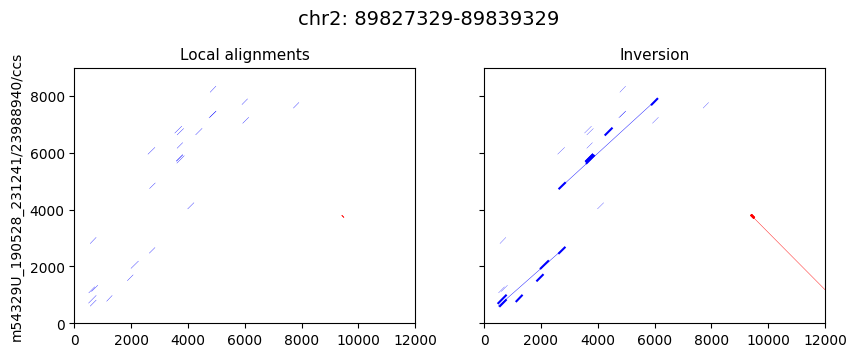

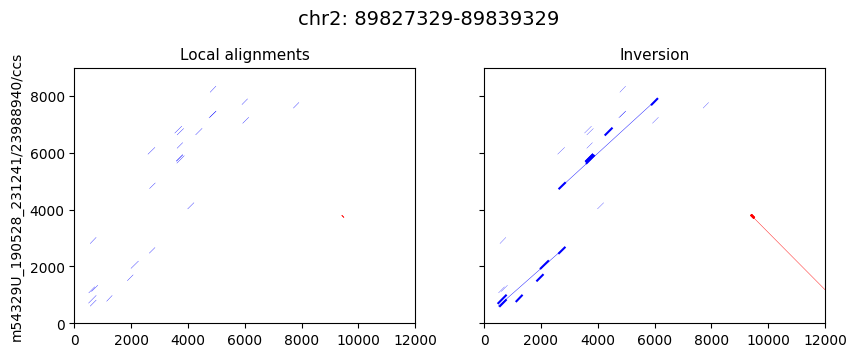

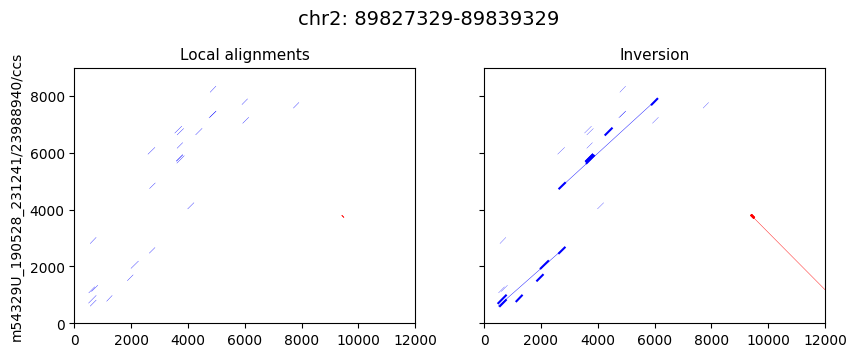

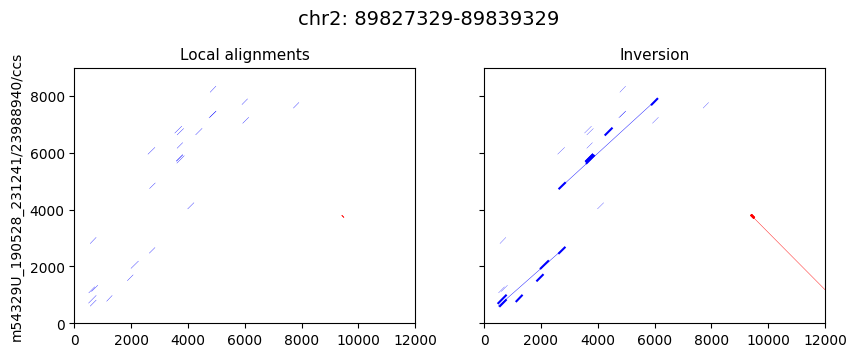

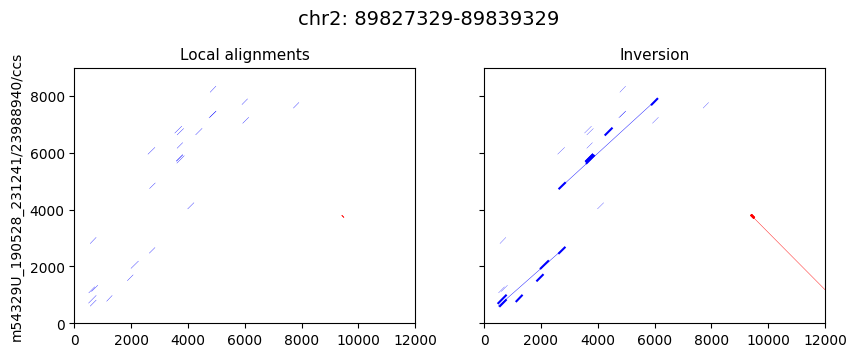

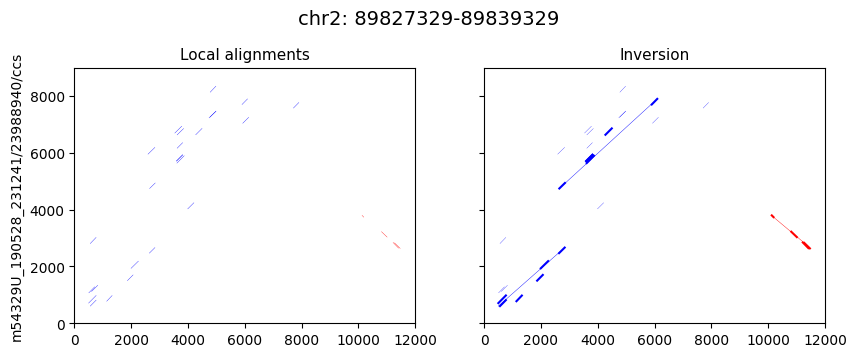

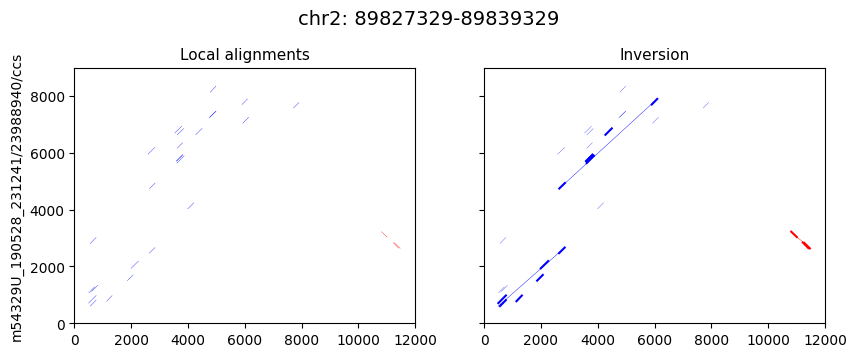

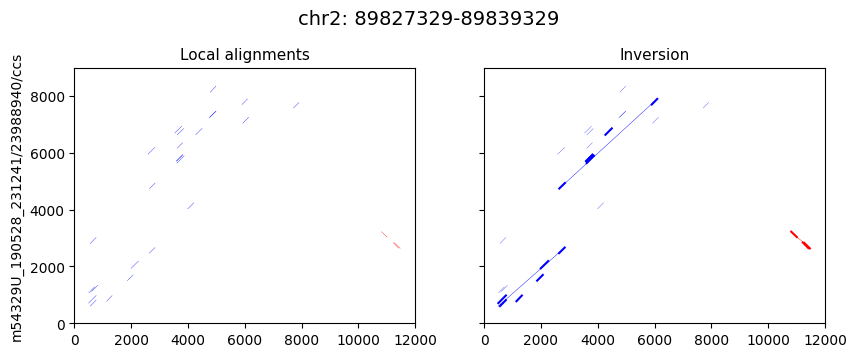

In [36]:
for reads in read_sets:
    for inv_sets in other_set_sets:
        for inv_set in inv_sets:
            qname = inv_set.qname.iloc[0]
            qbreakpoint = np.max(inv_set["qend"])
            above_breakpoint = reads[(reads["qname"] == qname) & (reads["strand"] == "+") & (reads["qbegin"] >= qbreakpoint * 0.9)]
            below_breakpoint = reads[(reads["qname"] == qname) & (reads["strand"] == "+") & (reads["qend"] <= qbreakpoint * 0.9)]

            above_read_sets, above_reads = get_single_aligned(above_breakpoint, max_offset = 400,
                                                                min_seq_count = 6,
                                                                min_seq_range = 1500,
                                                                single_strand = True)
            below_read_sets, below_reads = get_single_aligned(below_breakpoint, max_offset = 400,
                                                                min_seq_count = 6,
                                                                min_seq_range = 1500,
                                                                single_strand = True)

            for i in range(len(above_read_sets)):
                for j in range(len(below_read_sets)):
                    above_set = above_read_sets[i]
                    below_set = pd.concat([below_read_sets[j], reads[(reads["qbegin"] < qbreakpoint) &  (reads["qend"] > qbreakpoint)]])
                    vbreakpoint = np.min(above_set["dbegin"]) + 200
                    below_set = below_set[below_set["dbegin"] < vbreakpoint]
                    plot_breakpoint(reads.copy(), above_set.copy(), below_set.copy(), inv_set.copy())

#### Optimal alignment

In [183]:
inv_set = other_set_sets[0][6].copy()
inv_set.drop([235], inplace = True)

In [195]:
reads = read_sets[0].copy()
len(reads)

30

In [196]:
#reads["pos"] = (reads["dbegin"] + reads["dend"] + reads["qbegin"] + reads["qend"]) // 10
#reads.sort_values(["pos", "len"], inplace = True, ascending = False)
#reads.drop_duplicates(subset = ["pos"], inplace = True, keep = "first")
len(reads)

30

In [124]:
#fig, ax = plt.subplots(1, 2)

#plot_inversion(pd.concat([reads, inv_set]), ax[0])

qname = inv_set.qname.iloc[0]
qbreakpoint = np.max(inv_set["qend"])
print(qbreakpoint)
above_breakpoint = reads[(reads["qname"] == qname) & (reads["strand"] == "+") & (reads["qbegin"] >= qbreakpoint * 0.9)]
below_breakpoint = reads[(reads["qname"] == qname) & (reads["strand"] == "+") & (reads["qend"] <= qbreakpoint * 0.9)]

above_read_sets, above_reads = get_single_aligned(above_breakpoint, max_offset = 200,
                                                                min_seq_count = 2,
                                                                min_seq_range = 1500,
                                                                single_strand = True)
below_read_sets, below_reads = get_single_aligned(below_breakpoint, max_offset = 200,
                                                                min_seq_count = 2,
                                                                min_seq_range = 1500,
                                                                single_strand = True)
#print(below_read_sets)
for i in range(len(above_read_sets)):
    for j in range(len(below_read_sets)):
        above_set = above_read_sets[i]
        below_set = pd.concat([below_read_sets[j], reads[(reads["qbegin"] < qbreakpoint) &  (reads["qend"] > qbreakpoint)]])
        vbreakpoint = np.min(above_set["dbegin"]) + 200
        below_set = below_set[below_set["dbegin"] < vbreakpoint]
        plot_breakpoint(reads, above_set, below_set, inv_set)

8579.0
1	m54329U_190528_231241/23988940/ccs	chr2


In [ ]:
pid = "HG00732"
df = read_stellar_output(pid + "_var.fp.gff")
len(df)

In [ ]:
selected_df = pd.read_csv(pid + "_reads_of_interest.tsv", sep = "\t", header = None)
selected_df.columns = ["qname", "dname"]
selected_df.head()

In [ ]:
df = df[df["dname"].isin(selected_df["dname"])]
df = df[df["qname"].isin(selected_df["qname"])]
df.head()

In [ ]:
df = get_split_variants(df)
len(df)

In [ ]:
df = switch_reverse_coord(df)
df = fit_line_coord(df)
df.head()

In [ ]:
read_sets, split_reads = get_best_aligned(df, max_offset = 1000, 
                                              min_seq_count = 2, 
                                              min_seq_range = 1000, 
                                              single_strand = False)
len(split_reads)

In [ ]:
other_set_sets = plot_all_inversions(read_sets, df)

In [ ]:
for inv_sets in other_set_sets:
    for inv_set in inv_sets:
        qname = inv_set.qname.iloc[0]
        qbreakpoint = np.max(inv_set["qend"])
        above_breakpoint = df[(df["qname"] == qname) & (df["strand"] == "+") & (df["qbegin"] >= qbreakpoint * 0.99)]
        below_breakpoint = df[(df["qname"] == qname) & (df["strand"] == "+") & (df["qend"] <= qbreakpoint * 1.01)]

        above_read_sets, above_reads = get_single_aligned(above_breakpoint, max_offset = 1000,
                                                            min_seq_count = 2,
                                                            min_seq_range = 20,
                                                            single_strand = True)
        below_read_sets, below_reads = get_single_aligned(below_breakpoint, max_offset = 1000,
                                                            min_seq_count = 2,
                                                            min_seq_range = 20,
                                                            single_strand = True)

        for i in range(len(above_read_sets)):
            for j in range(len(below_read_sets)):
                above_set = above_read_sets[i]
                below_set = pd.concat([below_read_sets[j], df[(df["qbegin"] < qbreakpoint) &  (df["qend"] > qbreakpoint)]])
                plot_breakpoint(df, above_set, below_set, inv_set)

### HG00731

In [21]:
pid = "HG00731"
df = read_stellar_output("new_variants/" + pid + "_var.fp.gff")
len(df)

701182

In [ ]:
selected_df = pd.read_csv(pid + "_reads_of_interest.tsv", sep = "\t", header = None)
selected_df.columns = ["qname", "dname"]
selected_df.head()

In [ ]:
df = df[df["dname"].isin(selected_df["dname"])]
df = df[df["qname"].isin(selected_df["qname"])]
df = get_split_variants(df)
len(df)

In [ ]:
df = switch_reverse_coord(df)
df = fit_line_coord(df)
df.head()

In [ ]:
read_sets, split_reads = get_best_aligned(df, max_offset = 1000, 
                                              min_seq_count = 2, 
                                              min_seq_range = 1000, 
                                              single_strand = False)
len(split_reads)

In [ ]:
other_set_sets = plot_all_inversions(read_sets, df)

#### Breakpoint for inverted duplication

In [ ]:
for inv_sets in other_set_sets:
    for inv_set in inv_sets:
        qname = inv_set.qname.iloc[0]
        qbreakpoint = np.max(inv_set["qend"])
        above_breakpoint = df[(df["qname"] == qname) & (df["strand"] == "+") & (df["qbegin"] >= qbreakpoint * 0.99)]
        below_breakpoint = df[(df["qname"] == qname) & (df["strand"] == "+") & (df["qend"] <= qbreakpoint * 1.01)]

        above_read_sets, above_reads = get_best_aligned(above_breakpoint, max_offset = 1000,
                                                        min_seq_count = 2,
                                                        min_seq_range = 20,
                                                        single_strand = True)
        below_read_sets, below_reads = get_best_aligned(below_breakpoint, max_offset = 1000,
                                                        min_seq_count = 2,
                                                        min_seq_range = 20,
                                                        single_strand = True)

        for i in range(len(above_read_sets)):
            for j in range(len(below_read_sets)):
                above_set = above_read_sets[i]
                below_set = pd.concat([below_read_sets[j], df[(df["qbegin"] < qbreakpoint) &  (df["qend"] > qbreakpoint)]])
                plot_breakpoint(df, above_set, below_set, inv_set)
    

### NA19238

In [42]:
pid = "NA19238"
df = read_stellar_output(pid + "_var.fp.gff")
len(df)

37914

In [40]:
selected_df = pd.read_csv(pid + "_reads_of_interest.tsv", sep = "\t", header = None)
selected_df.columns = ["qname", "dname"]
selected_df.head()

,qname,dname
0,m64039_190830_040857/150014756/ccs,chr2
1,m64039_190830_040857/173474075/ccs,chr5


In [43]:
#df = df[df["dname"].isin(selected_df["dname"])]
#df = df[df["qname"].isin(selected_df["qname"])]
df = get_split_variants(df)
len(df)

5500

In [44]:
df = switch_reverse_coord(df)
df = fit_line_coord(df)
df.head()

,dname,dbegin,dend,percid,strand,len,qname,qbegin,qend,a,b
25900,chr21,7918143.0,7918196.0,98.1481,+,53.0,m64039_190830_040857/100008688/ccs,9380.0,9433.0,1.0,-7908763.0
25933,chr21,7918143.0,7918197.0,98.1818,+,54.0,m64039_190830_040857/100008688/ccs,9385.0,9439.0,1.0,-7908758.0
26374,chr21,7926161.0,7926214.0,98.1481,+,53.0,m64039_190830_040857/100008688/ccs,9382.0,9435.0,1.0,-7916779.0
26760,chr21,7927256.0,7927312.0,98.2456,+,56.0,m64039_190830_040857/100008688/ccs,9382.0,9438.0,1.0,-7917874.0
27035,chr21,7927258.0,7927316.0,98.3050,+,58.0,m64039_190830_040857/100008688/ccs,9379.0,9437.0,1.0,-7917879.0


In [45]:
read_sets, split_reads = get_best_aligned(df, max_offset = 2000, 
                                              min_seq_count = 1, 
                                              min_seq_range = 20, 
                                              single_strand = False)
len(split_reads)

1	m64039_190830_040857/112067248/ccs	chr2
2	m64039_190830_040857/112067248/ccs	chr2
3	m64039_190830_040857/112067248/ccs	chr2
4	m64039_190830_040857/112067248/ccs	chr2
5	m64039_190830_040857/112067248/ccs	chr2
6	m64039_190830_040857/112067248/ccs	chr2
7	m64039_190830_040857/112067248/ccs	chr2
8	m64039_190830_040857/112067248/ccs	chr2
9	m64039_190830_040857/112067248/ccs	chr2
10	m64039_190830_040857/112067248/ccs	chr2
11	m64039_190830_040857/112067248/ccs	chr2
12	m64039_190830_040857/112067248/ccs	chr2
13	m64039_190830_040857/112067248/ccs	chr2
14	m64039_190830_040857/112067248/ccs	chr2
15	m64039_190830_040857/112067248/ccs	chr2
16	m64039_190830_040857/112067248/ccs	chr2
17	m64039_190830_040857/112067248/ccs	chr2
18	m64039_190830_040857/112067248/ccs	chr2
19	m64039_190830_040857/146669943/ccs	chr1
20	m64039_190830_040857/146669943/ccs	chr1
21	m64039_190830_040857/146669943/ccs	chr1
22	m64039_190830_040857/146669943/ccs	chr1
23	m64039_190830_040857/146669943/ccs	chr1
24	m64039_190830_040

83

In [46]:
other_set_sets = plot_all_inversions(read_sets, df)

Match count on other strand	10
Other strand match set count	1
Match count on other strand	10
Other strand match set count	2
Match count on other strand	10
Other strand match set count	3
Match count on other strand	10
Other strand match set count	4
Match count on other strand	5
Other strand match set count	5
Match count on other strand	5
Other strand match set count	6
Match count on other strand	5
Other strand match set count	7
Match count on other strand	5
Other strand match set count	8
Match count on other strand	4
Other strand match set count	9
Match count on other strand	4
Other strand match set count	10
Match count on other strand	4
Other strand match set count	11
Match count on other strand	4
Other strand match set count	12
Match count on other strand	4
Other strand match set count	13
Match count on other strand	4
Other strand match set count	14
Match count on other strand	3
Other strand match set count	15
Match count on other strand	3
Other strand match set count	16
Match count o

In [ ]:
for inv_sets in other_set_sets:
    for inv_set in inv_sets:
        qname = inv_set.qname.iloc[0]
        qbreakpoint = np.max(inv_set["qend"])
        above_breakpoint = df[(df["qname"] == qname) & (df["strand"] == "+") & (df["qbegin"] >= qbreakpoint * 0.99)]
        below_breakpoint = df[(df["qname"] == qname) & (df["strand"] == "+") & (df["qend"] <= qbreakpoint * 1.01)]

        above_read_sets, above_reads = get_single_aligned(above_breakpoint, max_offset = 2000,
                                                        min_seq_count = 2,
                                                        min_seq_range = 20,
                                                        single_strand = True)
        below_read_sets, below_reads = get_single_aligned(below_breakpoint, max_offset = 2000,
                                                        min_seq_count = 2,
                                                        min_seq_range = 20,
                                                        single_strand = True)

        for i in range(len(above_read_sets)):
            for j in range(len(below_read_sets)):
                above_set = above_read_sets[i]
                below_set = pd.concat([below_read_sets[j], df[(df["qbegin"] < qbreakpoint) &  (df["qend"] > qbreakpoint)]])
                plot_breakpoint(df, above_set, below_set, inv_set)

### NA19239

In [ ]:
pid = "NA19239"
df = read_stellar_output(pid + "_var.fp.gff")
len(df)

In [ ]:
df = get_split_variants(df)
len(df)

In [ ]:
df = switch_reverse_coord(df)
df = fit_line_coord(df)
df.head()

In [ ]:
read_sets, split_reads = get_best_aligned(df, max_offset = 1500, 
                                              min_seq_count = 3, 
                                              min_seq_range = 100, 
                                              single_strand = False)
len(split_reads)

In [ ]:
other_set_sets = plot_all_inversions(read_sets, df)

In [ ]:
for inv_sets in other_set_sets:
    for inv_set in inv_sets:
        qname = inv_set.qname.iloc[0]
        qbreakpoint = np.max(inv_set["qend"])
        region_begin = inv_set.dbegin.iloc[0]
        above_breakpoint = df[(df["qname"] == qname) & (df["strand"] == "+") & (df["qbegin"] >= qbreakpoint * 0.99) & (df["dbegin"] > region_begin - 20000) & (df["dbegin"] < region_begin + 20000)]
        below_breakpoint = df[(df["qname"] == qname) & (df["strand"] == "+") & (df["qend"] <= qbreakpoint * 1.01) & (df["dbegin"] > region_begin - 20000) & (df["dbegin"] < region_begin + 20000)]

        above_read_sets, above_reads = get_best_aligned(above_breakpoint, max_offset = 1500,
                                                        min_seq_count = 2,
                                                        min_seq_range = 20,
                                                        single_strand = True)
        below_read_sets, below_reads = get_best_aligned(below_breakpoint, max_offset = 1500,
                                                        min_seq_count = 2,
                                                        min_seq_range = 20,
                                                        single_strand = True)

        for i in range(len(above_read_sets)):
            for j in range(len(below_read_sets)):
                above_set = above_read_sets[i]
                below_set = pd.concat([below_read_sets[j], df[(df["qbegin"] < 1000) &  (df["qend"] > 1000)]])
                plot_breakpoint(df, above_set, below_set, inv_set)